**Este test es el último test y es el que anda mejor**
- Falta hacer una representación de los puntos en el espacio

In [10]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import joblib
from scipy.spatial.distance import cdist

**PATHS**

In [11]:
image_path      = '../../../dataset/images'
training_path   = os.path.join(image_path, 'training')
original_path   = os.path.join(training_path, 'original')
processed_path  = os.path.join(training_path, 'processed')

**LISTAS DE IMAGENES**

In [12]:
original   = [os.path.join(original_path, image) for image in os.listdir(original_path)]
processed  = [os.path.join(processed_path, image) for image in os.listdir(processed_path)]

**PROPIA IMPLEMENTACIÓN DE KMEANS**

In [71]:
def kmeans(n_clusters, features, tol = 1e-4, max_iter = 300):
    
    centroids = [features[np.random.choice(features.shape[0])]]

    for _ in range(1, n_clusters):
        # Calcular las distancias cuadradas desde los centroides actuales a cada punto
        dist_sq = np.array([min([np.linalg.norm(c - x)**2 for c in centroids]) for x in features])

        # Calcular las probabilidades de elegir cada punto como próximo centroide
        probabilities = dist_sq / np.sum(dist_sq)

        # Elegir el próximo centroide usando las probabilidades
        next_centroid = features[np.random.choice(features.shape[0], p=probabilities)]
        centroids.append(next_centroid)

    centroids = np.array(centroids)
    '''centroids   = []
    range_min   = np.min(features, axis = 0)  # El mínimo de las componentes de los vectores
    range_max   = np.max(features, axis = 0)  # El máximo de las componentes de los vectores

    centroids = np.random.uniform(range_min, range_max, size = (n_clusters, features.shape[1]))'''
    # Obtenemos los centroides iniciales de forma aleatoria
    '''for _ in range(n_clusters):
        centroid = np.random.uniform(range_min, range_max, size = (3,))
        centroids.append(centroid)'''

    # Los colocamos a los centroiddes como filas de una matriz
    centroids = np.vstack(centroids)

    for _ in range(max_iter):
        # Clusters
        clusters        = []
        labels          = np.empty(features.shape[0])
        new_centroids   = []
        
        # Distancias de cada punto a cada centroide
        dist        = cdist(centroids, features)
        sorted_ind  = np.argsort(dist, axis = 0)

        # Construcción de los clusters
        # Y recalculo de los centroides
        
        for j in range(n_clusters):
            index         = sorted_ind[0, :] == j
            cluster       = features[index, :]
            labels[index] = j
            clusters.append(cluster)
            centroid      = np.mean(cluster, axis = 0)
            new_centroids.append(centroid)
        new_centroids = np.vstack(new_centroids)

        # Verificamos condicion de parada por tolerancia
        dist = np.linalg.norm(centroids - new_centroids, axis = 1)
        if np.max(dist) < tol:
            break

        centroids = new_centroids
    # Devolvemos la matriz que tiene por filas los centroides.
        
    # Devolvemos la lisya que tiene por elementos las matrices que tienen por filas
    # los puntos del cluster.
    
    # Devolvemos la lista de labels que indican la pertenencia a un cluster de cada elemento.
    return  list(labels), clusters, centroids

**RANGOS DE COLOR**

- Los siguientes rangos de colores son lo mejorcito

In [15]:
lower_red_2 = np.array([170, 60, 60])
upper_red_2 = np.array([179, 255, 255])

lower_red_1 = np.array([0, 60, 60])
upper_red_1 = np.array([8, 255, 255])

lower_orange = np.array([8, 120, 80])
upper_orange = np.array([21, 255, 255])

lower_yellow = np.array([21, 50, 80])
upper_yellow = np.array([25, 255, 255])

lower_green = np.array([25, 40, 40])
upper_green = np.array([100, 255, 255])

In [16]:
labels  = []

for image_file, mask_file in zip(original, processed):
    # Leer la imagen y la máscara
    image = cv2.imread(image_file)
    mask  = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aplicar la máscara
    fruit = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    # Contar el número de píxeles en cada rango
    conteo = {
        'V' : np.sum(np.all(np.logical_and(lower_green  <= fruit, fruit <= upper_green), axis=-1)),
        'R1': np.sum(np.all(np.logical_and(lower_red_1  <= fruit, fruit <= upper_red_1), axis=-1)),
        'R2': np.sum(np.all(np.logical_and(lower_red_2  <= fruit, fruit <= upper_red_2), axis=-1)),
        'A' : np.sum(np.all(np.logical_and(lower_yellow <= fruit, fruit <= upper_yellow), axis=-1)),
        'N' : np.sum(np.all(np.logical_and(lower_orange <= fruit, fruit <= upper_orange), axis=-1))
    }
    conteo_por_rango = {
        'V': conteo['V'],
        'R': conteo['R1'] + conteo['R2'],
        'A': conteo['A'],
        'N': conteo['N']
    }

    sorted_conteo = sorted(conteo_por_rango.items(), key=lambda x: x[1], reverse=True)

    # Obtener el segundo elemento más grande
    segundo_mas_grande = sorted_conteo[1]

    # Obtener la etiqueta y el valor del segundo elemento más grande
    etiqueta_segundo_mas_grande = segundo_mas_grande[0]
    valor_segundo_mas_grande    = segundo_mas_grande[1]

    # Obtener la etiqueta basándose en el rango con el mayor conteo
    etiqueta = max(conteo_por_rango, key = conteo_por_rango.get)
    if (etiqueta_segundo_mas_grande == 'R')and(valor_segundo_mas_grande > 0.35*conteo_por_rango[etiqueta]):
        etiqueta = 'R'
        
    labels.append(etiqueta)

**Pasamos la lista de labels a una lìsta de coordenadas para las frutas**

In [17]:
conversions = {'V' :-20, 'R' : -10, 'A' : 10, 'N' : 20}
coordinates = []
for label in labels:
    coordinates.append(conversions[label])

**Pasamos las coordenadas a un diccionario primero para combinarlo con las circularidades**

In [18]:
names   = [os.path.basename(file) for file in original]
colores = dict.fromkeys(names)
for coordinate, key in zip(coordinates, colores.keys()):
    colores[key] = coordinate

**Ahora probamos con los momentos de Hu**

- En principio andan bien los momentos de Hu desde el 1 hasta el 3. Esos son los que usamos pero de todas maneras no permiten la separación del grupos de las naranjas de las manzanas anaranjadas así que las vamos a eliminar

In [19]:
hu = dict.fromkeys(names)

for name, mask_file in zip(hu.keys(), processed):
    image_file  = os.path.join(original_path, name)
    image       = cv2.imread(image_file)
    mask        = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Recuperar la fruta utilizando la máscara
    fruit   = cv2.bitwise_and(image, image, mask = mask)

    # Encontrar el rectángulo delimitador de la fruta
    (x, y, w, h) = cv2.boundingRect(mask)

    # Recortar la imagen original para obtener solo la región de la fruta
    trimed  = fruit[y:y + h, x:x + w]

    # Convertir la imagen a escala de grises si es necesario
    trimed_gray = cv2.cvtColor(trimed, cv2.COLOR_BGR2GRAY)

    # Calcular los momentos de la imagen
    momentos = cv2.moments(trimed_gray)

    # Calcular los momentos de Hu
    momentos_hu = cv2.HuMoments(momentos)

    # Aplicar logaritmo a los momentos de Hu para mejorar la escala
    log_moments_hu = -np.sign(momentos_hu) * np.log10(np.abs(momentos_hu))
    log_moments_hu = log_moments_hu.reshape(-1)
    hu[name]       = log_moments_hu

**Unimos las medidas**

In [20]:
combinacion = dict.fromkeys(names)
for key, moment in hu.items():
    combinacion[key] = np.append(moment[2:4], colores[key])

In [78]:
# Obtener los valores de circularidad como un array de NumPy
features = np.vstack(list(combinacion.values()))

# Especificar el número de clusters (k)
num_clusters = 4

# Aplicamos kmeans
labels,_,_ = kmeans(num_clusters, features)

**Agrupamiento de archivos y sus características en los cluster para representacion**

Para representacion de las imagenes de un mismo cluster

In [79]:
clusters = dict.fromkeys(set(labels))
for file, label in zip(combinacion.keys(), labels):
    if clusters[label] is None:
        clusters[label] = []
    clusters[label].append(file)

Para representación de los puntos de características en el espacio

In [80]:
# Crear el diccionario features_dict
features_dict = dict.fromkeys(set(labels))

# Iterar sobre los labels únicos y organizar los vectores en el diccionario
for label in features_dict.keys():
    # Filtrar los vectores que corresponden a este label
    cluster = features[labels == label, :]
    
    # Almacenar los vectores en el diccionario
    features_dict[label] = cluster

In [81]:
joblib.dump(features_dict, 'features.pkl')

['features.pkl']

0.0


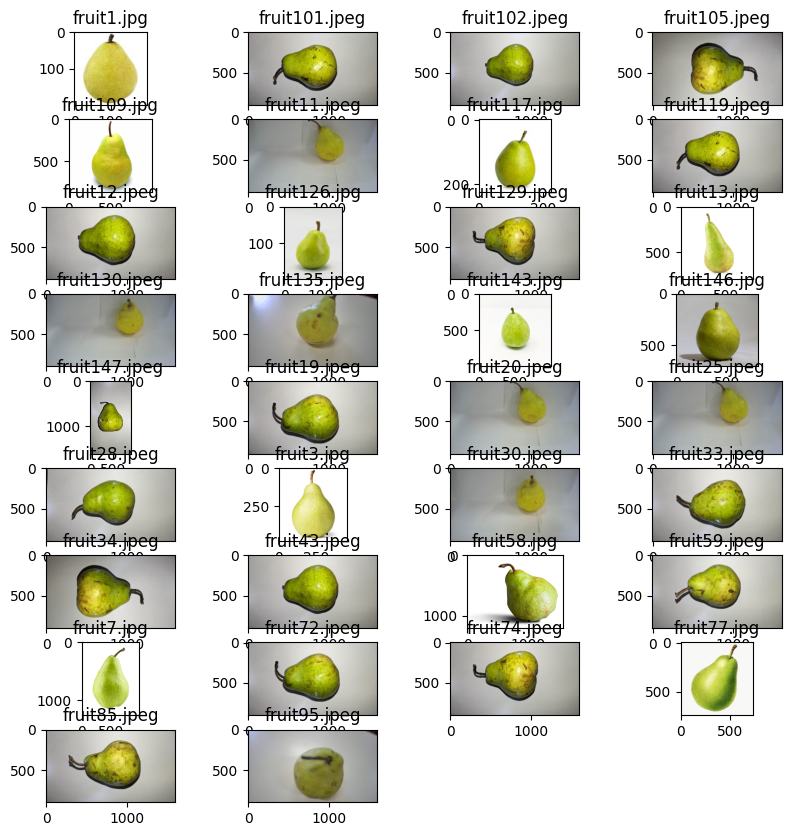

1.0


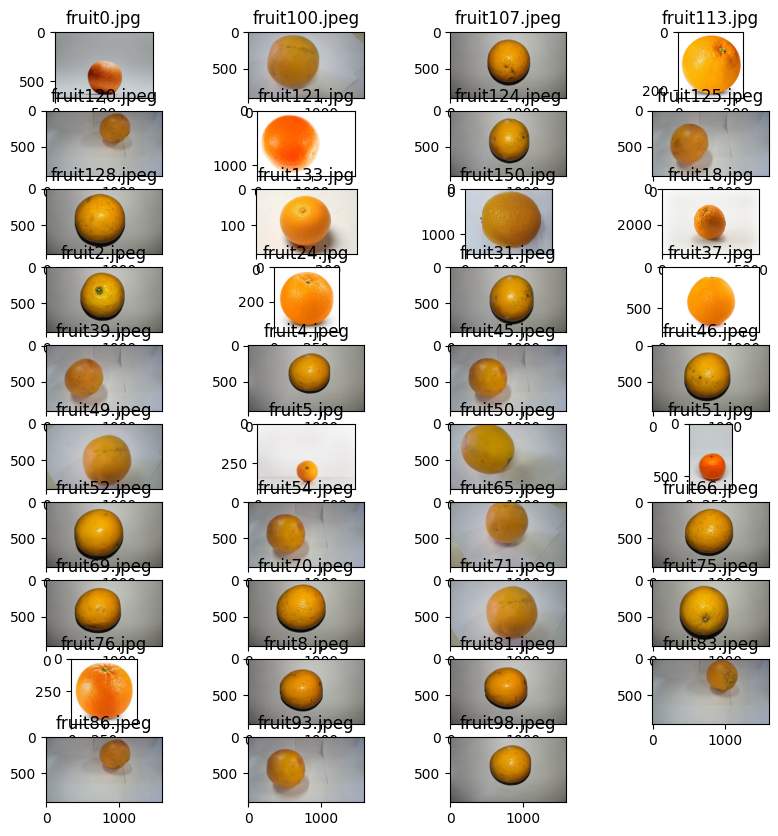

2.0


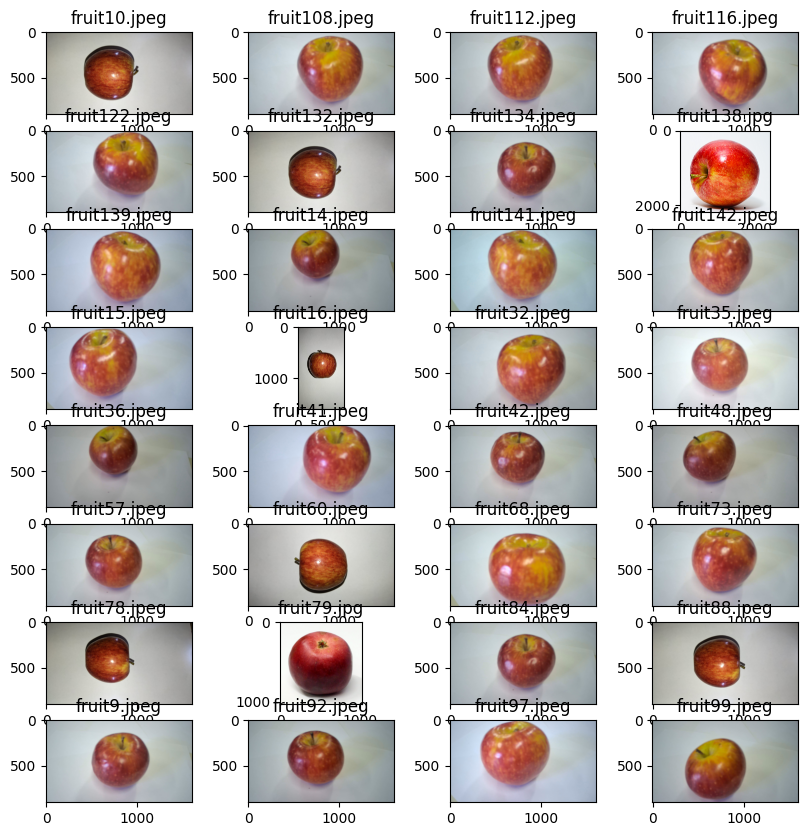

3.0


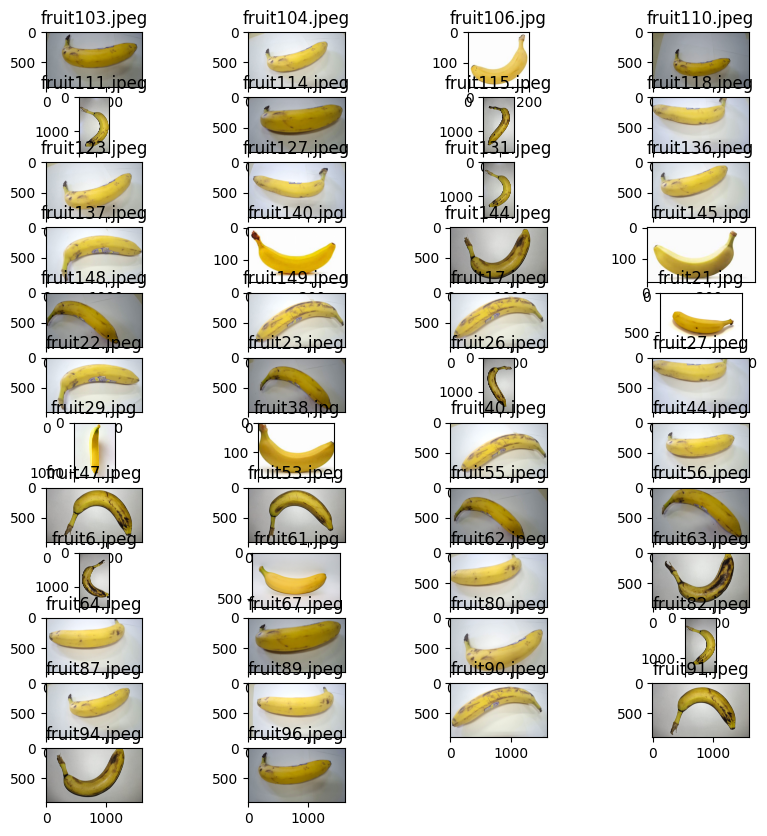

In [82]:
for key, cluster in clusters.items():
    print(key)
    cols = 4
    rows = len(cluster)//cols

    if len(cluster)%cols != 0:
        rows += 1

    plt.figure(figsize = (10, 10))
    for i, element in enumerate(cluster):
        file = os.path.join(original_path, element)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(file))
    plt.show()

**PROBAMOS LA REPRESENTACIÓN DE LOS PUNTOS EN EL ESPACIO**

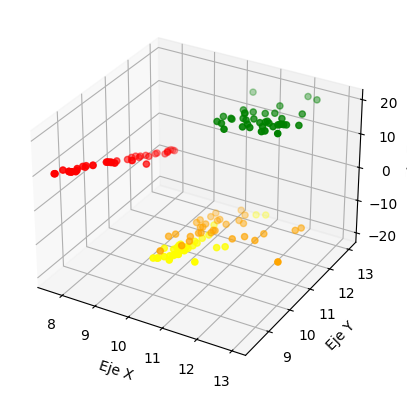

In [83]:
#3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = dict(zip(features_dict.keys(), ['yellow','green','orange','red']))

for key, cluster in features_dict.items():
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colors[key], marker='o', label=key)
        
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
plt.show()